In [1]:
"""
- Normal
    - Tension_Normal.csv
    - NTRNL_Normal # subfolder
        - 05-31 23_35_19.txt
        ...
    - XTRNL_Normal # subfolder
        - 20230531_233519.csv
        ...
- CoreExposed
    - Tension_CoreExposed.csv
    - NTRNL_CoreExposed # subfolder
        - 06-01 16_04_36.txt
        ...
    - XTRNL_CoreExposed # subfolder
        - 20230601_160436.csv
        ...
- CoreSevered
    - Tension_CoreSevered.csv
    - NTRNL_CoreSevered # subfolder
        - 06-01 01_49_17.txt
        ...
    - XTRNL_CoreSevered # subfolder
        - 20230601_014917.csv
        ...
- SideDamaged
    - Tension_SideDamaged.csv
    - NTRNL_SideDamaged # subfolder
        - 05-31 20_54_14.txt
        ...
    - XTRNL_SideDamaged # subfolder
        - 20230531_205414.csv
        ...
"""

'\n- Normal\n    - Tension_Normal.csv\n    - NTRNL_Normal # subfolder\n        - 05-31 23_35_19.txt\n        ...\n    - XTRNL_Normal # subfolder\n        - 20230531_233519.csv\n        ...\n- CoreExposed\n    - Tension_CoreExposed.csv\n    - NTRNL_CoreExposed # subfolder\n        - 06-01 16_04_36.txt\n        ...\n    - XTRNL_CoreExposed # subfolder\n        - 20230601_160436.csv\n        ...\n- CoreSevered\n    - Tension_CoreSevered.csv\n    - NTRNL_CoreSevered # subfolder\n        - 06-01 01_49_17.txt\n        ...\n    - XTRNL_CoreSevered # subfolder\n        - 20230601_014917.csv\n        ...\n- SideDamaged\n    - Tension_SideDamaged.csv\n    - NTRNL_SideDamaged # subfolder\n        - 05-31 20_54_14.txt\n        ...\n    - XTRNL_SideDamaged # subfolder\n        - 20230531_205414.csv\n        ...\n'

In [2]:
import numpy as np
import pandas as pd
import glob
import os
import scipy.stats
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_selection import mutual_info_classif
from sklearn.decomposition import PCA
from scipy.spatial import distance
import warnings

##### 수집한 신호로부터 대푯값 추출 및 표준화
##### 변수 'Tension', 'Mean', 'Variance', 'Skewness', 'Kurtosis', 'Type', 'ConfucionMatrix' 생성

In [3]:
Directory_Path = 'C:/Users/99kit/Desktop/CapstoneDesign2/'
list_root_directory = ['Normal', 'CoreExposed', 'CoreSevered', 'SideDamaged']

def calculate_statistics(data):
    mean = np.mean(data)
    var = np.var(data)
    skew = scipy.stats.skew(data)
    kurt = scipy.stats.kurtosis(data)
    return mean, var, skew, kurt

data_frames = {}

for directory in list_root_directory:
    os.chdir(os.path.join(Directory_Path, directory))

    Tension = pd.read_csv(f"Tension_{directory}.csv", encoding='cp949')
    Tension['Unnamed: 0'] = pd.to_datetime(Tension['Unnamed: 0'], format='[%Y/%m/%d] %H:%M:%S')
    Tension['Formatted_Time'] = Tension['Unnamed: 0'].dt.strftime(f'NTRNL_{directory}\\%m-%d %H_%M_%S.txt')

    list_max_values = []
    for csv_file in glob.glob('*/*.csv'):
        df = pd.read_csv(csv_file)
        list_max_values.append(df['External Sound'].max())
    Tension['Max_EXT_Sound'] = list_max_values

    statistics = {}
    for txt_file in glob.glob('*/*.txt'):
        with open(txt_file, 'r') as file:
            data = [int(line.strip().split(',')[0]) for line in file if len(line.strip().split(',')) == 3]
            statistics[txt_file] = calculate_statistics(data)

    for stat_name in ['Mean', 'Variance', 'Skewness', 'Kurtosis']:
        Tension[stat_name] = Tension['Formatted_Time'].map(lambda x: statistics.get(x, (np.nan, np.nan, np.nan, np.nan))[['Mean', 'Variance', 'Skewness', 'Kurtosis'].index(stat_name)])
        Tension[stat_name].interpolate(inplace=True)

    Q1 = Tension['Max_EXT_Sound'].quantile(0.25)
    Q3 = Tension['Max_EXT_Sound'].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers_max_ext_sound = Tension[(Tension['Max_EXT_Sound'] < lower_bound) | (Tension['Max_EXT_Sound'] > upper_bound)]

    Q1_mean = Tension['Mean'].quantile(0.25)
    Q3_mean = Tension['Mean'].quantile(0.75)
    IQR_mean = Q3_mean - Q1_mean
    lower_bound_mean = Q1_mean - 1.5 * IQR_mean
    upper_bound_mean = Q3_mean + 1.5 * IQR_mean
    outliers_mean_ntrnl_sound = Tension[(Tension['Mean'] < lower_bound_mean) | (Tension['Mean'] > upper_bound_mean)]

    common_indices = outliers_max_ext_sound.index.intersection(outliers_mean_ntrnl_sound.index)
    Tension.loc[common_indices, 'Mean'] = np.nan
    Tension['Mean'].interpolate(inplace=True)

    Tension = Tension.drop(['Formatted_Time', 'Max_EXT_Sound'], axis=1)
    Tension['Type'] = directory

    Tension.loc[Tension['Type'] != 'Normal', 'Confusion Matrix'] = 'Anomaly'
    Tension.loc[Tension['Type'] == 'Normal', 'Confusion Matrix'] = 'Normal'

    data_frames[directory] = Tension

tb_data = pd.concat(data_frames.values(), ignore_index=True)
tb_data = tb_data.rename(columns={'벨트처짐': 'Tension'})

list_independent_variables = ['Tension', 'Mean', 'Variance', 'Skewness', 'Kurtosis']

data_standardized = StandardScaler().fit_transform(tb_data[list_independent_variables])
tb_data_standardized = pd.DataFrame(data_standardized, columns=list_independent_variables)
tb_data[list_independent_variables] = tb_data_standardized

tb_data

,Unnamed: 0,Tension,Mean,Variance,Skewness,Kurtosis,Type,Confusion Matrix
0,2023-05-31 23:35:19,-0.216452,-1.780290,0.235485,-0.209677,0.005047,Normal,Normal
1,2023-05-31 23:35:20,-0.204667,-0.470556,0.059753,0.655876,-0.858885,Normal,Normal
2,2023-05-31 23:35:21,-0.216452,-1.040747,0.163329,0.333842,-0.392346,Normal,Normal
3,2023-05-31 23:35:22,-0.240023,-1.600883,0.503912,-0.609384,-0.731790,Normal,Normal
4,2023-05-31 23:35:23,-0.240023,-0.172642,1.351871,0.541339,-1.517878,Normal,Normal
...,...,...,...,...,...,...,...,...
14250,2023-05-31 21:53:55,-0.298951,-1.252192,-1.108551,-2.155222,1.508766,SideDamaged,Anomaly
14251,2023-05-31 21:53:56,-0.240023,-0.831468,-0.717530,0.131856,0.607366,SideDamaged,Anomaly
14252,2023-05-31 21:53:57,0.007473,-0.539040,0.135900,0.228446,-0.148179,SideDamaged,Anomaly
14253,2023-05-31 21:53:58,-0.263594,0.162395,-1.534583,0.175456,1.726651,SideDamaged,Anomaly


##### 4가지 Type의 분포 확인
##### Mutual Information(상호 정보량)을 이용한 변수 중요도 파악
##### 주성분 분석을 이용한 차원 축소

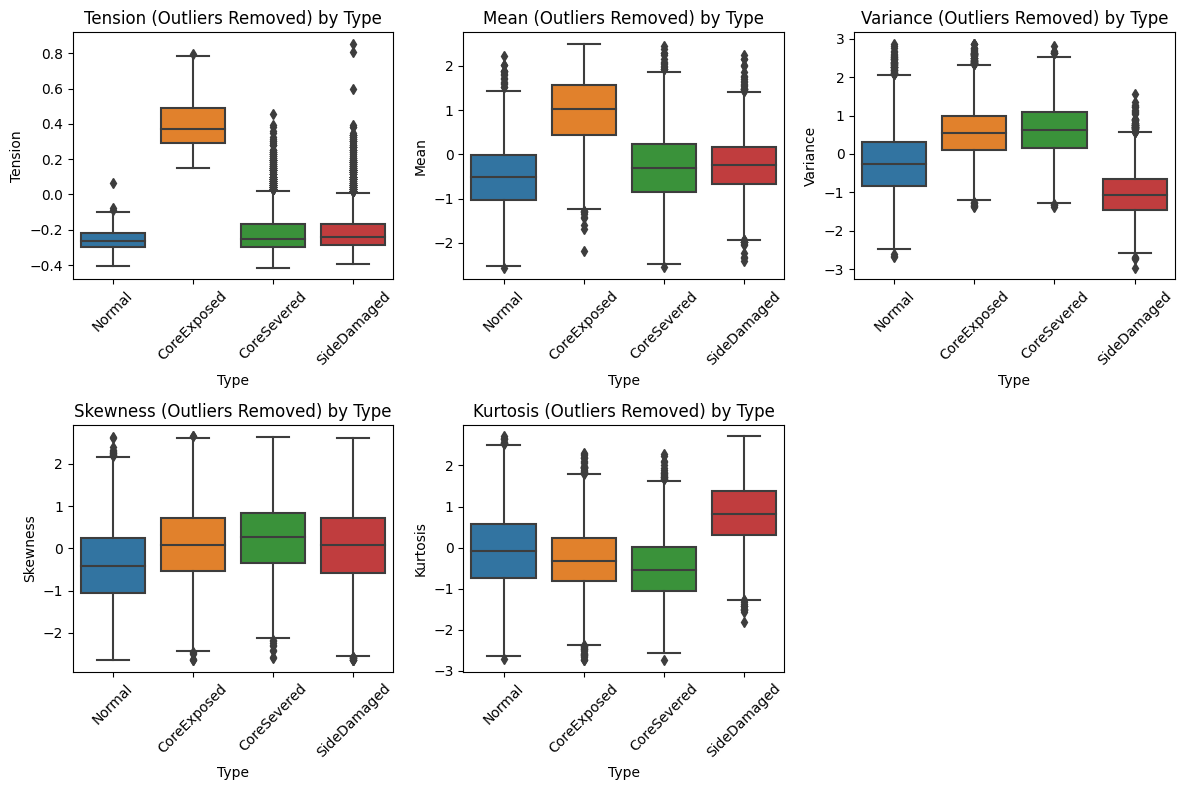

In [4]:
# 박스 플롯 그리기
plt.figure(figsize=(12, 8))  # 그림 크기 설정

# 각 열에 대해 이상치 제거한 박스 플롯 그리기
for i, col in enumerate(list_independent_variables, 1):
    plt.subplot(2, 3, i)  # 2x3 그리드에서 i번째 위치에 서브플롯 생성

    # 이상치 제거 (IQR 기반)
    Q1 = tb_data[col].quantile(0.25)
    Q3 = tb_data[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    data_no_outliers = tb_data[(tb_data[col] >= lower_bound) & (tb_data[col] <= upper_bound)]

    sns.boxplot(x='Type', y=col, data=data_no_outliers)
    plt.title(f'{col} (Outliers Removed) by Type')  # 서브플롯 제목 설정
    plt.xlabel('Type')  # x축 레이블 설정
    plt.ylabel(col)  # y축 레이블 설정
    plt.xticks(rotation=45)  # x축 레이블 회전

plt.tight_layout()  # 레이아웃 조정
plt.show()

변수 중요도
Tension     0.571682
Variance    0.326099
Mean        0.237760
Kurtosis    0.169220
Skewness    0.023525
dtype: float64


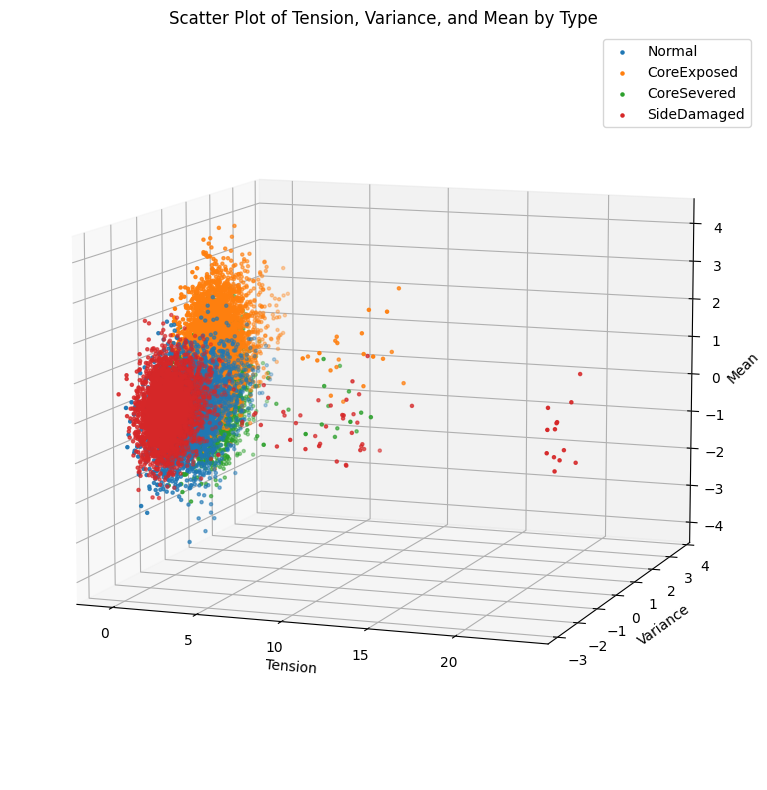

In [5]:
# 독립 변수와 타겟 변수를 선택
X = tb_data[list_independent_variables]  # 독립 변수
y = tb_data['Type']  # 타겟 변수

# 상호 정보량 계산
mutual_info = mutual_info_classif(X, y, discrete_features='auto', random_state=42)

# 결과 출력
importance_scores = pd.Series(mutual_info, index=X.columns)
importance_scores = importance_scores.sort_values(ascending=False)
print('변수 중요도')
print(importance_scores)

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

tension = tb_data['Tension']
variance = tb_data['Variance']
mean = tb_data['Mean']
type = tb_data['Type']

for t in tb_data['Type'].unique().tolist():
    mask = type == t
    ax.scatter(tension[mask], variance[mask], mean[mask], label = t, marker = '.')

ax.set_xlabel('Tension', rotation=45)
ax.set_ylabel('Variance', rotation=45)
ax.set_zlabel('Mean', rotation=45)

azimuth_angle = -70
elevation_angle = 10
ax.view_init(elev=elevation_angle, azim=azimuth_angle)

ax.legend()
plt.title('Scatter Plot of Tension, Variance, and Mean by Type')
plt.tight_layout()
plt.show()

주성분의 누적 설명력: [0.38105984 0.62837282 0.83513909 0.97441389 1.        ]


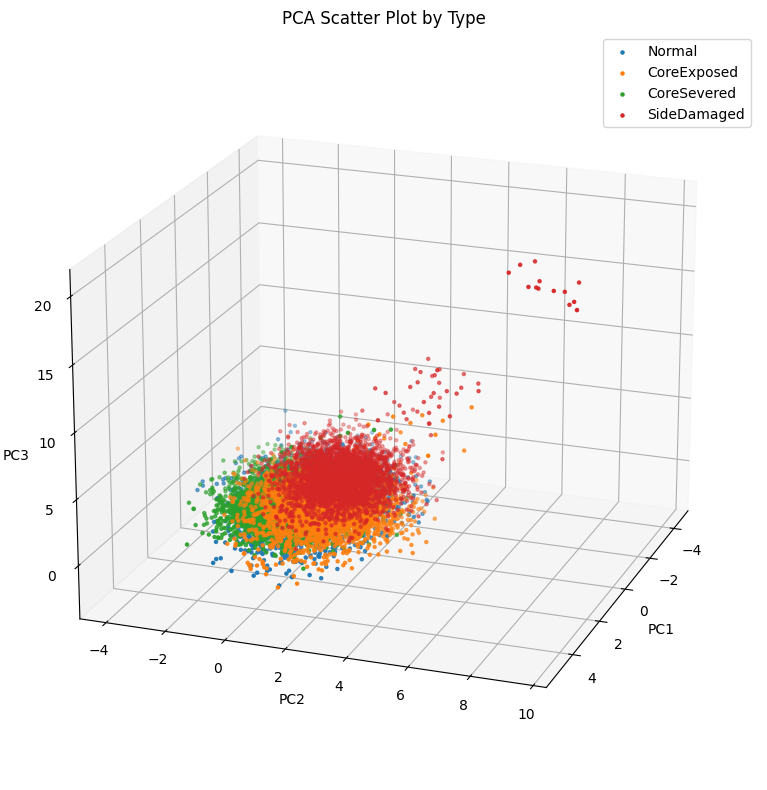

In [6]:
pca = PCA()
pca_tb_data = pca.fit_transform(tb_data[list_independent_variables])
list_pca_tb_data_cols = [f'PC{i+1}' for i in range(pca_tb_data.shape[1])]
pca_tb_data = pd.concat([pd.DataFrame(data = pca_tb_data, columns = list_pca_tb_data_cols), tb_data[['Type', 'Confusion Matrix']]], axis = 1)

explained_var_ratio_cumsum = np.cumsum(pca.explained_variance_ratio_)
print(f'주성분의 누적 설명력: {explained_var_ratio_cumsum}')

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection = '3d')

pc1 = pca_tb_data['PC1']
pc2 = pca_tb_data['PC2']
pc3 = pca_tb_data['PC3']
type = pca_tb_data['Type']

for t in pca_tb_data['Type'].unique().tolist():
    mask = type == t
    ax.scatter(pc1[mask], pc2[mask], pc3[mask], label = t, marker = '.')

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')

azimuth_angle = 20
elevation_angle = 20
ax.view_init(elev=elevation_angle, azim=azimuth_angle)

plt.legend()
plt.title('PCA Scatter Plot by Type')
plt.tight_layout()
plt.show()

##### Normal과 Anomaly 데이터의 분포 비교
##### 상호 정보량을 이용한 변수 중요도 파악
##### 주성분 분석을 이용한 차원 축소

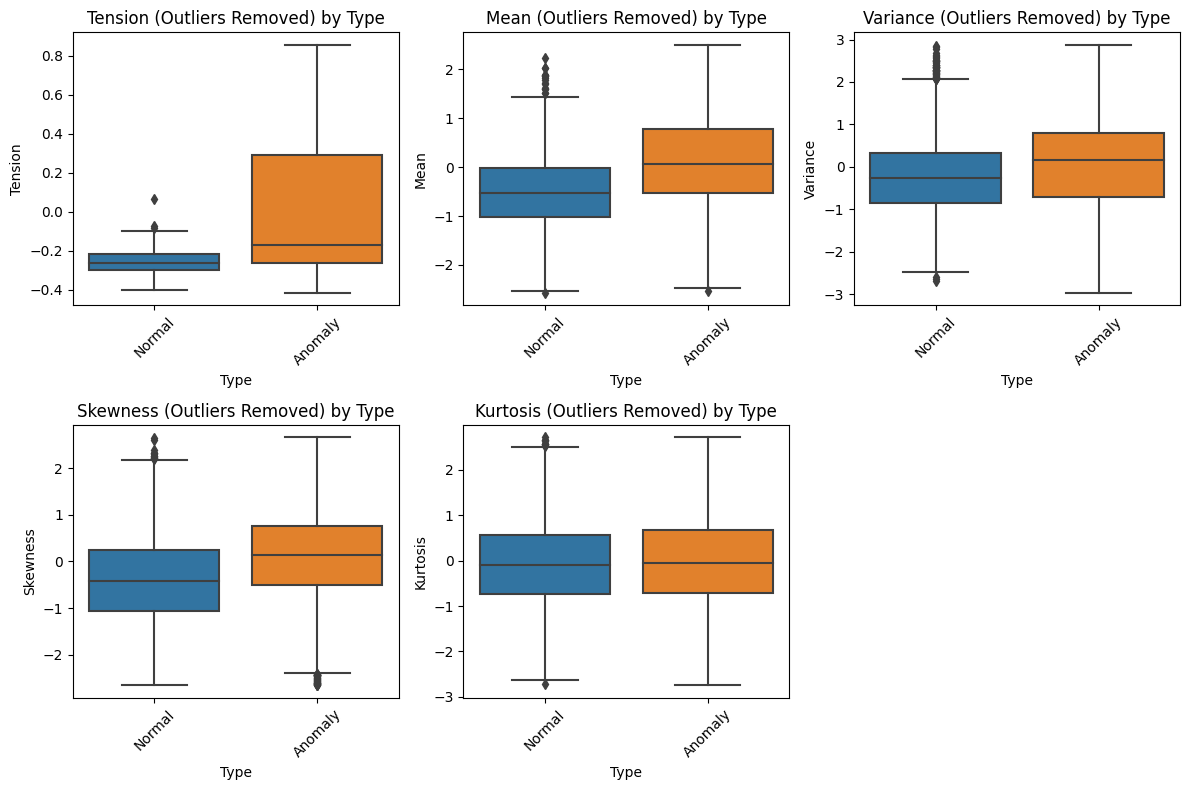

In [7]:
# 박스 플롯 그리기
plt.figure(figsize=(12, 8))  # 그림 크기 설정

# 각 열에 대해 이상치 제거한 박스 플롯 그리기
for i, col in enumerate(list_independent_variables, 1):
    plt.subplot(2, 3, i)  # 2x3 그리드에서 i번째 위치에 서브플롯 생성

    # 이상치 제거 (IQR 기반)
    Q1 = tb_data[col].quantile(0.25)
    Q3 = tb_data[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    data_no_outliers = tb_data[(tb_data[col] >= lower_bound) & (tb_data[col] <= upper_bound)]

    sns.boxplot(x='Confusion Matrix', y=col, data=data_no_outliers)
    plt.title(f'{col} (Outliers Removed) by Type')  # 서브플롯 제목 설정
    plt.xlabel('Type')  # x축 레이블 설정
    plt.ylabel(col)  # y축 레이블 설정
    plt.xticks(rotation=45)  # x축 레이블 회전

plt.tight_layout()  # 레이아웃 조정
plt.show()

변수 중요도
Tension     0.120450
Mean        0.050333
Skewness    0.028058
Variance    0.021103
Kurtosis    0.001922
dtype: float64


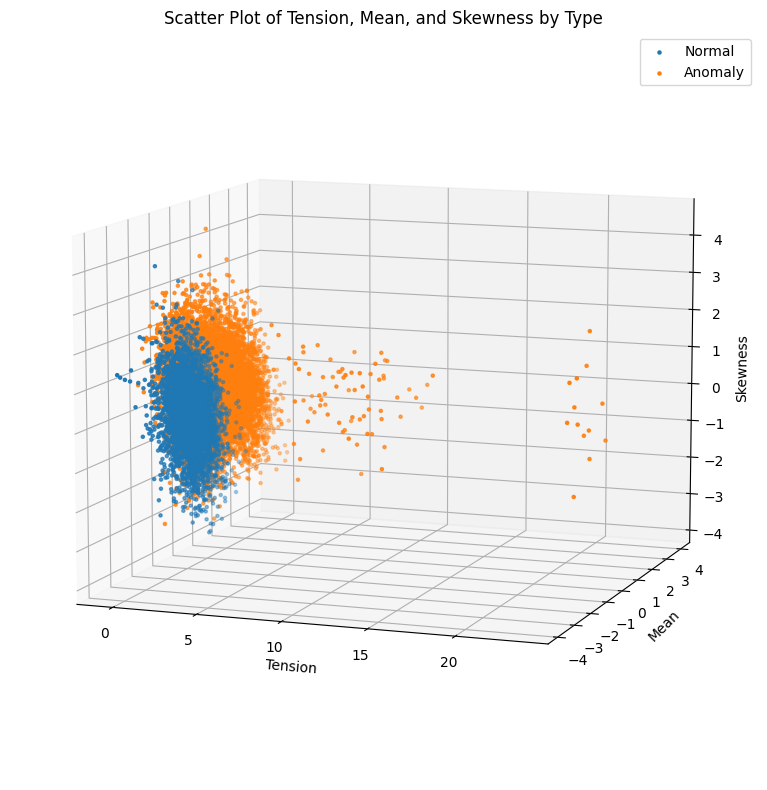

In [8]:
# 독립 변수와 타겟 변수를 선택
X = tb_data[list_independent_variables]  # 독립 변수
y = tb_data['Confusion Matrix']  # 타겟 변수

# 상호 정보량 계산
mutual_info = mutual_info_classif(X, y, discrete_features='auto', random_state=42)

# 결과 출력
importance_scores = pd.Series(mutual_info, index=X.columns)
importance_scores = importance_scores.sort_values(ascending=False)
print('변수 중요도')
print(importance_scores)

fig = plt.figure(figsize=(12, 8))

ax = fig.add_subplot(111, projection='3d')
tension = tb_data['Tension']
mean = tb_data['Mean']
skewness = tb_data['Skewness']
confusion_matrix = tb_data['Confusion Matrix']

for t in tb_data['Confusion Matrix'].unique().tolist():
    mask = confusion_matrix == t
    ax.scatter(tension[mask], mean[mask], skewness[mask], label = t, marker = '.')

ax.set_xlabel('Tension', rotation=45)
ax.set_ylabel('Mean', rotation=45)
ax.set_zlabel('Skewness', rotation=45)

azimuth_angle = -70
elevation_angle = 10
ax.view_init(elev=elevation_angle, azim=azimuth_angle)

ax.legend()
plt.title('Scatter Plot of Tension, Mean, and Skewness by Type')
plt.tight_layout()
plt.show()

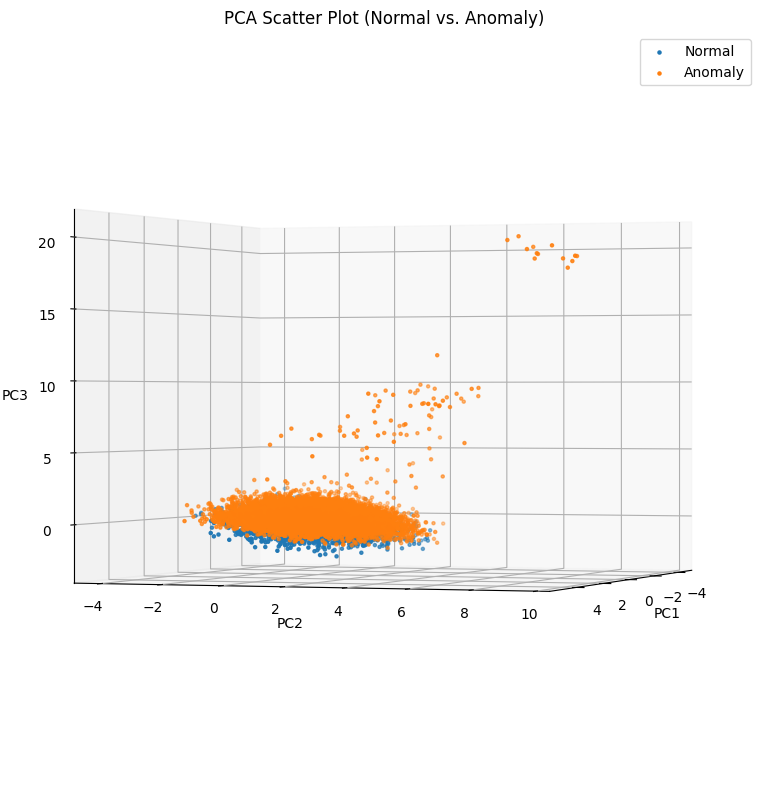

In [9]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection = '3d')

pc1 = pca_tb_data['PC1']
pc2 = pca_tb_data['PC2']
pc3 = pca_tb_data['PC3']
type = pca_tb_data['Confusion Matrix']

for t in pca_tb_data['Confusion Matrix'].unique().tolist():
    mask = type == t
    ax.scatter(pc1[mask], pc2[mask], pc3[mask], label = t, marker = '.')

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')

azimuth_angle = 20
elevation_angle = 0
ax.view_init(elev=elevation_angle, azim=azimuth_angle)

plt.legend()
plt.title('PCA Scatter Plot (Normal vs. Anomaly)')
plt.tight_layout()
plt.show()

##### Normal에 대해 집단과 데이터 포인트 사이의 Mahalanobis 거리 계산
##### 신뢰수준(n%)을 정하고 여러 개의 n분위수를 Bootstrap을 이용하여 구한 뒤 그 평균을 관리한계로 설정
##### 제1종 오류(유의수준) 및 제2종 오류 발생

In [10]:
warnings.filterwarnings('ignore') # 모든 경고 메시지 무시

type_normal = tb_data[tb_data['Type'] == 'Normal']
type_not_normal = tb_data[tb_data['Type'] != 'Normal']

normal_mean = type_normal[list_independent_variables].mean()
normal_cov = type_normal[list_independent_variables].cov()

def mahalanobis_distance(row):
    x = row[list_independent_variables]
    return distance.mahalanobis(x, normal_mean, normal_cov)

type_normal['Mahalanobis Distance'] = type_normal.apply(mahalanobis_distance, axis = 1)

bootstrap_iterations = 500
confidence_level = 95

list_bootstrap_statistics = []

for _ in range(bootstrap_iterations):
    bootstrap_sample = np.random.choice(type_normal['Mahalanobis Distance'], size = len(type_normal), replace = True)
    list_bootstrap_statistics.append(np.percentile(bootstrap_sample, confidence_level))

control_limit = np.mean(list_bootstrap_statistics)
print(f'confidence level: {confidence_level}%')
print(f'control limit: {control_limit}')

type_not_normal['Mahalanobis Distance'] = type_not_normal.apply(mahalanobis_distance, axis = 1)

type_normal.loc[type_normal['Mahalanobis Distance'] >= control_limit, 'Confusion Matrix'] = 'Type1Error' # 'Normal' = TrueNegative
type_not_normal.loc[type_not_normal['Mahalanobis Distance'] <= control_limit, 'Confusion Matrix'] = 'Type2Error' # 'Anomaly' = TruePositive

tb_data = pd.concat([type_normal, type_not_normal], axis = 0)

tb_data

confidence level: 95%
control limit: 3.573674206199146


,Unnamed: 0,Tension,Mean,Variance,Skewness,Kurtosis,Type,Confusion Matrix,Mahalanobis Distance
0,2023-05-31 23:35:19,-0.216452,-1.780290,0.235485,-0.209677,0.005047,Normal,Normal,1.109174
1,2023-05-31 23:35:20,-0.204667,-0.470556,0.059753,0.655876,-0.858885,Normal,Normal,1.373444
2,2023-05-31 23:35:21,-0.216452,-1.040747,0.163329,0.333842,-0.392346,Normal,Normal,1.126269
3,2023-05-31 23:35:22,-0.240023,-1.600883,0.503912,-0.609384,-0.731790,Normal,Normal,1.522023
4,2023-05-31 23:35:23,-0.240023,-0.172642,1.351871,0.541339,-1.517878,Normal,Normal,2.703300
...,...,...,...,...,...,...,...,...,...
14250,2023-05-31 21:53:55,-0.298951,-1.252192,-1.108551,-2.155222,1.508766,SideDamaged,Type2Error,2.539571
14251,2023-05-31 21:53:56,-0.240023,-0.831468,-0.717530,0.131856,0.607366,SideDamaged,Type2Error,1.295017
14252,2023-05-31 21:53:57,0.007473,-0.539040,0.135900,0.228446,-0.148179,SideDamaged,Type2Error,0.712283
14253,2023-05-31 21:53:58,-0.263594,0.162395,-1.534583,0.175456,1.726651,SideDamaged,Type2Error,2.965364


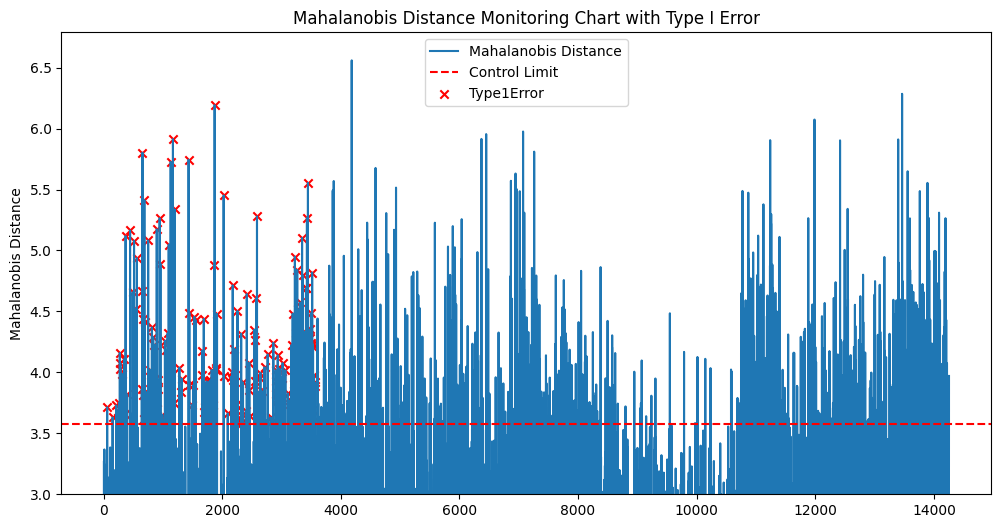

In [11]:
mahalanobis_distance = tb_data['Mahalanobis Distance']

type1_error_indices = tb_data[tb_data['Confusion Matrix'] == 'Type1Error'].index

plt.figure(figsize=(12, 6))

plt.plot(mahalanobis_distance, label='Mahalanobis Distance') # Mahalanobis Distance 그래프 그리기

plt.axhline(y=control_limit, color='red', linestyle='--', label='Control Limit') # Control Limit 그래프 그리기

plt.scatter(type1_error_indices, mahalanobis_distance[type1_error_indices], c='red', marker='x', label='Type1Error') # 'Confusion Matrix' 값이 'Type1Error'인 데이터 포인트 표시

plt.ylabel('Mahalanobis Distance')
plt.title('Mahalanobis Distance Monitoring Chart with Type Ⅰ Error')
plt.legend()

plt.ylim(3, control_limit * 1.9) # y축 범위 설정

plt.show()

변수 중요도
Variance    0.136696
Kurtosis    0.122333
Tension     0.120592
Mean        0.058083
Skewness    0.048229
dtype: float64


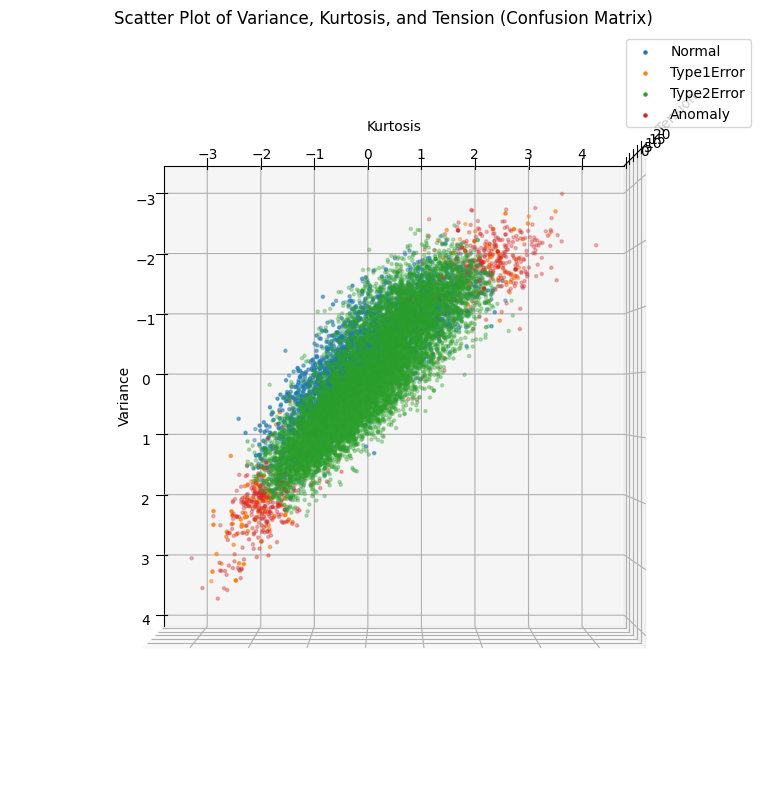

In [12]:
X = tb_data[list_independent_variables]  # 독립 변수
y = tb_data['Confusion Matrix']  # 타겟 변수

# 상호 정보량 계산
mutual_info = mutual_info_classif(X, y, discrete_features='auto', random_state=42)

# 결과 출력
importance_scores = pd.Series(mutual_info, index=X.columns)
importance_scores = importance_scores.sort_values(ascending=False)
print('변수 중요도')
print(importance_scores)

fig = plt.figure(figsize=(12, 8))

ax = fig.add_subplot(111, projection='3d')
variance = tb_data['Variance']
kurtosis = tb_data['Kurtosis']
tension = tb_data['Tension']
confusion_matrix = tb_data['Confusion Matrix']

for t in tb_data['Confusion Matrix'].unique().tolist():
    mask = confusion_matrix == t
    ax.scatter(variance[mask], kurtosis[mask], tension[mask], label = t, marker = '.')

ax.set_xlabel('Variance', rotation=45)
ax.set_ylabel('Kurtosis', rotation=45)
ax.set_zlabel('Tension', rotation=45)

azimuth_angle = 0
elevation_angle = 90
ax.view_init(elev=elevation_angle, azim=azimuth_angle)

ax.legend()
plt.title('Scatter Plot of Variance, Kurtosis, and Tension (Confusion Matrix)')
plt.tight_layout()
plt.show()